# Script to check various properties of the data

In [225]:
# Call packages
import numpy as np 
import pandas as pd 
import scipy.stats as stats
import matplotlib.pyplot as plt
from util.formatting.mid_price_from_orderbook import save_mid_price

In [228]:
# Retrieve and save midprice
save_mid_price("log/historic_test004/ORDERBOOK_IBM_FREQ_T.bz2", "log/historic_test004/")

Processing order book: 100%|██████████| 390/390 [00:00<00:00, 870.93it/s]


In [229]:
# Read midprice data
mid_price = pd.read_pickle("log/historic_test004/ORDERBOOK_IBM_FREQ_T_mid_price.bz2")

### Stylised facts to check

Note the following:

\begin{equation}
m_t = \frac{a_t + b_t}{2}
\end{equation}

\begin{equation}
r_{t,\Delta t} = ln(m_{t + \Delta t}) - ln(m_t)
\end{equation}




- Absence of autocorrelations in periods greater than 20 minutes - we will set the asset return times scale $(\Delta t)$ to between 1 minute and 60 min


\begin{equation}
corr(r_{t + \tau, \Delta t}, r_{t, \Delta t})
\end{equation}


-- *This looks fairly promissing* --



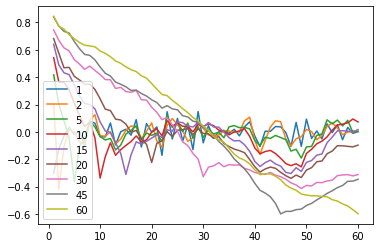

In [230]:
# set correlation period and asset return interval

# check correlation period of upto an hour
corr_period = range(1, 61)
asset_return_interval = [1,2,5,10,15,20,30,45,60]
corr = pd.DataFrame(index=corr_period, columns=asset_return_interval)


# Convert price data to asset returns data
for i in asset_return_interval:

    returns = mid_price.diff(periods=i)[i:]
    dummy = []

    # Convert asset returns data to correlation over set periods 
    for j in corr_period:
        
        dummy.append(np.corrcoef(returns[0:-1*j], returns[j:])[0, 1])

    corr[i] = dummy

    # Plot correlation
    plt.plot(np.linspace(1,60,60), corr[i], label=i)

plt.legend()


- Heavy tails and aggregation normality (high kurtosis)

--*This looks fairly promissing*--


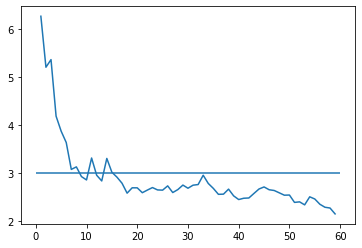

In [239]:
asset_return_interval = range(1,60)
kurtosis = []

# Convert price data to asset returns data
#fig, ax = plt.subplots(nrows=len(asset_return_interval), ncols=1, figsize=(5, len(asset_return_interval)*5))
axis = 0

for i in asset_return_interval:

    # calculate asset returns
    returns = mid_price.diff(periods=i)[i:]

    """
    # plot
    ax[axis].hist(returns, 50)
    axis += 1
    """

    # record kurtosis
    kurtosis.append(stats.kurtosis(returns, fisher=False))

plt.plot(asset_return_interval, kurtosis)
plt.hlines(3, xmin=0, xmax=60)

- Intermittency (Can't really measure this)


- Volatility clustering - we will set the asset return times scale $(\Delta t)$ to between 1 minute and 60 min
 


\begin{equation}
corr(r_{t + \tau, \Delta t}^2, r_{t, \Delta t}^2)
\end{equation}

*--Again, fairly promissing--*

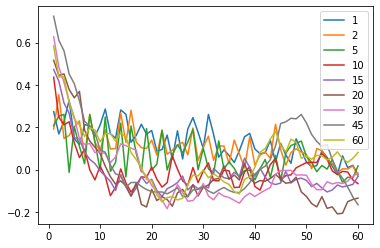

In [241]:
# set correlation period and asset return interval

# check correlation period of upto an hour
corr_period = range(1, 61)
asset_return_interval = [1,2,5,10,15,20,30,45,60]
corr = pd.DataFrame(index=corr_period, columns=asset_return_interval)


# Convert price data to asset returns data
for i in asset_return_interval:

    returns = mid_price.diff(periods=i)[i:]
    dummy = []

    # Convert asset returns data to correlation over set periods 
    for j in corr_period:
        
        dummy.append(np.corrcoef(returns[0:-1*j]**2, returns[j:]**2)[0, 1])

    corr[i] = dummy

    # Plot correlation
    plt.plot(np.linspace(1,60,60), corr[i], label=i)

plt.legend()

- Long range dependence (not sure how to measure this)

- Gain/Loss asymmetry (Can measure this, but only pronounced for the equity market)

- Volume/volatility positive correlation - not so good. We need a way to find actual volume as opposed to LOB volume

In [258]:
df = pd.read_pickle("log/historic_test004/ExchangeAgent0.bz2")

df = df[df['EventType'] == 'LAST_TRADE']
if len(df) <= 0:
    print("There appear to be no simulated trades.")
    sys.exit()
df['PRICE'] = [y for x,y in df['Event'].str.split(',')]
df['SIZE'] = [x for x,y in df['Event'].str.split(',')]
df['PRICE'] = df['PRICE'].str.replace('$','').astype('float64')
df['SIZE'] = df['SIZE'].astype('float64')

# New code for minutely resampling and renaming columns.
df = df[["PRICE","SIZE"]].resample("1T")
df_open = df["PRICE"].first().ffill()
df_close = df["PRICE"].last().ffill()
df_high = df["PRICE"].max().ffill()
df_low = df["PRICE"].min().ffill()
df_vol = df["SIZE"].sum()
ohlcv = pd.DataFrame({
    "open": df_open,
    "high": df_high,
    "low": df_low,
    "close": df_close,
    "volume": df_vol
})
ohlcv = ohlcv.iloc[:390,:]

In [259]:


# set correlation period and asset return interval

# check correlation period of upto an hour
asset_return_interval = [1]#,2,5,10,15,20,30,45,60]
vol_period = 240

volume_set = []
volatility_set = []

# Convert price data to asset returns data
for i in asset_return_interval:

    returns = ohlcv.open.diff(periods=i)[i:]
    volume  = ohlcv.volume[i:]

    for j in range(len(volume) - vol_period):

        volume_set.append(np.sum(volume[j:j+vol_period]))
        volatility_set.append(np.std(returns[j:j+vol_period]))

    print(np.corrcoef(volume_set, volatility_set))



[[1.         0.83385796]
 [0.83385796 1.        ]]


- Returns/volatility negative correlation

In [260]:


# set correlation period and asset return interval

# check correlation period of upto an hour
asset_return_interval = 15#,2,5,10,15,20,30,45,60]

returns_set = []
volatility_set = []

# Convert price data to asset returns data
returns_set = ohlcv.open.diff(periods=asset_return_interval)[asset_return_interval:]


for i in range(len(ohlcv) - asset_return_interval):

    volatility_set.append(np.std(ohlcv.open[i:i+asset_return_interval]))


print(np.corrcoef(returns_set, volatility_set))



[[1.         0.46637954]
 [0.46637954 1.        ]]



- Asymmetric causal information flow (not sure how to measure this)


- Best Bid/Ask distributed according to Gama distribution


In [261]:
df = pd.read_pickle("log/historic_test004/ExchangeAgent0.bz2")

df = df[df['EventType'] == 'LAST_TRADE']
if len(df) <= 0:
    print("There appear to be no simulated trades.")
    sys.exit()
df['PRICE'] = [y for x,y in df['Event'].str.split(',')]
df['SIZE'] = [x for x,y in df['Event'].str.split(',')]
df['PRICE'] = df['PRICE'].str.replace('$','').astype('float64')
df['SIZE'] = df['SIZE'].astype('float64')


order_stream = pd.DataFrame({
                            "Price": df.PRICE,
                            "Size": df.SIZE,
                            "Time": df.index
})

- Time correlation of order flow

  *definitely more orders at the start and end of market*

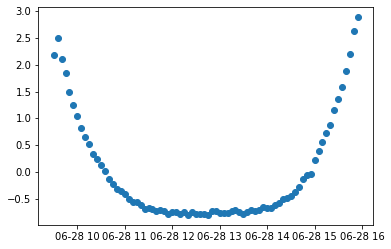

In [262]:
from sklearn import preprocessing

order_hist = order_stream.groupby([pd.Grouper(key = 'Time', freq='5T')]).sum()

plt.scatter(order_hist.index, preprocessing.scale(order_hist.Size))


- Order interarrival times are exponential/lognormal/Weibull

  *clearly exponential here*

(array([5.638e+03, 5.572e+03, 5.062e+03, 5.013e+03, 4.600e+03, 4.513e+03,
        4.345e+03, 3.949e+03, 3.743e+03, 3.708e+03, 3.472e+03, 3.315e+03,
        3.164e+03, 3.119e+03, 2.840e+03, 2.739e+03, 2.584e+03, 2.601e+03,
        2.423e+03, 2.407e+03, 2.222e+03, 2.078e+03, 2.008e+03, 1.891e+03,
        1.864e+03, 1.782e+03, 1.657e+03, 1.623e+03, 1.570e+03, 1.563e+03,
        1.396e+03, 1.439e+03, 1.384e+03, 1.306e+03, 1.240e+03, 1.208e+03,
        1.196e+03, 1.088e+03, 1.074e+03, 1.068e+03, 1.017e+03, 9.520e+02,
        9.790e+02, 9.650e+02, 9.070e+02, 8.150e+02, 8.740e+02, 8.160e+02,
        7.500e+02, 7.160e+02, 7.320e+02, 7.260e+02, 6.730e+02, 6.950e+02,
        6.740e+02, 5.910e+02, 5.690e+02, 6.420e+02, 5.710e+02, 6.120e+02,
        5.950e+02, 5.790e+02, 5.320e+02, 4.940e+02, 5.110e+02, 4.870e+02,
        5.150e+02, 4.810e+02, 4.220e+02, 4.420e+02, 4.450e+02, 4.550e+02,
        3.980e+02, 3.670e+02, 4.060e+02, 3.710e+02, 3.570e+02, 3.400e+02,
        3.700e+02, 3.240e+02, 3.400e+0

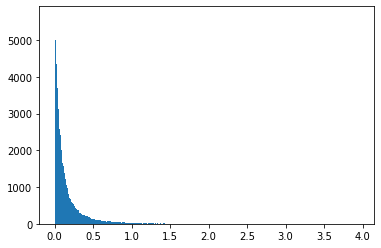

In [263]:
interarrival_times = order_stream.index[1:] - order_stream.index[:-1]
int_sec = interarrival_times.total_seconds()

plt.hist(int_sec, 1000)

- Number of orders in a fixed time window is approximated by gamma/lognormal distribution 

  *this is not so promissing. Should be lognormal*


In [264]:
start_time = pd.to_datetime("2019-06-28 09:30:00")
current_count = []
for i in range(385):

    count1 = (order_stream.index >= start_time)
    count2 =  (order_stream.index < start_time + pd.to_timedelta(5, "T"))

    current_count.append(np.sum(count1*count2))

    start_time += pd.to_timedelta(1, "T")


(array([169.,  40.,  23.,  21.,  14.,  11.,  13.,  11.,  12.,   7.,   7.,
          8.,   9.,   5.,   6.,   7.,   5.,   4.,   9.,   4.]),
 array([-0.80389245, -0.61703792, -0.43018338, -0.24332885, -0.05647432,
         0.13038022,  0.31723475,  0.50408928,  0.69094382,  0.87779835,
         1.06465288,  1.25150742,  1.43836195,  1.62521648,  1.81207102,
         1.99892555,  2.18578008,  2.37263462,  2.55948915,  2.74634368,
         2.93319822]),
 <BarContainer object of 20 artists>)

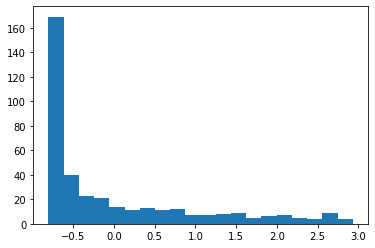

In [265]:
plt.hist(preprocessing.scale(current_count), 20)

- Order sizes are Power-law distributed
- New limit order prices are power-law distributed
- Lifetime of orders are power-law distributed
- Lower spreads during higher Volume